# Process

1. Generate time series output from Lorenz model, this is used to create the library set and test set. 
2. Reconstruct a library and test attractor by delay embedding the solution output from the Lorenz system. Then use knnsearch to find the nearest neighbor (residing in the library) for each point in the test trajectory.
3. Calculate lambda^- and lambda^+ as a function of local time (L) for the forward and backward trajectories. This is done in the function 'getlambda.m'.
4. Plot (lambda^-)-(lambda^+) as a function of L. The metric 'delta lambda', is the maximum of the curve (lambda^-)-(lambda^+), displayed in figure(1). 

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import neighbors
import scipy

## 1. Generate time series

In [8]:
def lorenz(sz=10000, max_t=100., noise=0, parameters=(10,8./3,28.0)):
    """Integrates the `lorenz equations`_. Which are defined as:
    .. math::
      \\frac{dx}{dt} = \\sigma (y - x)
      \\frac{dy}{dt} = x(\\rho - z) - y
      \\frac{dz}{dt} = xy - \\beta z
    Where :math:`\\sigma=10`, :math:`\\beta=8/3`, and :math:`\\rho=28` lead to
    chaotic behavior.
    Parameters
    ----------
    sz : int
        Length of the time series to be integrated.
    max_t : float
        Length of time to solve the lorenz equation over,
    noise : float
        Amplitude of noise to be added to the lorenz equation.
    parameters : tuple
        Sigma, beta, and rho parameters for the lorenz equations.
    Returns
    -------
    X : 2D array
        X solutions in the first column, Y in the second, and Z in the third.
    .. _lorenz equations: https://en.wikipedia.org/wiki/Lorenz_system
    """

    sigma, beta, rho = parameters

    def lorenz_deriv(xyz, t0, sigma=sigma, beta=beta, rho=rho):
        x,y,z = xyz
        return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

    x0 = [1, 1, 1]  # starting vector
    t = np.linspace(0, max_t, sz)  # one thousand time steps
    X = scipy.integrate.odeint(lorenz_deriv, x0, t) + noise*np.random.rand(sz,3)

    return X


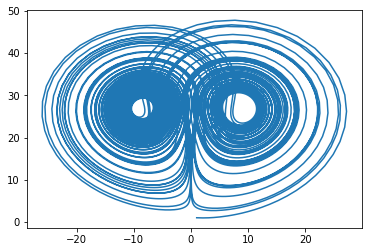

In [10]:
X = lorenz()
plt.plot(X[:,1], X[:,2])

In [82]:
def embed_ts(x, embed_dim, lag):
    x_out = [x.reshape(-1,1)]
    
    for i in range(1, embed_dim):
        x_roll = np.roll(x, i*lag).reshape(-1,1)
        x_out.append(x_roll)
    x_out = np.hstack(x_out)
    x_out = x_out[embed_dim*lag:]
    return x_out

def generate_feature_targets(x, feature_len):
    
    features = []
    targets_forward = []
    targets_backward = []
    for i in range(feature_len + 1, len(x)):
        f = x[i,:]
        t_forward = x[i+1:i+1+feature_len, :].ravel()
        t_backward = x[i-1:i-1-feature_len,:].ravel()
        
        if len(t_forward) < feature_len * xx.shape[1]:
            break
        
        features.append(f)
        targets_forward.append(t_forward)
        targets_backward.append(t_backward)
    return np.vstack(features), np.vstack(targets_forward), np.vstack(targets_backward)

In [84]:
features, targ_forward, targ_backward = generate_feature_targets(xx, 10)

In [66]:
_[0].shape

(3,)

In [34]:
X[:,1].reshape(-1,1)

array([[ 1.        ],
       [ 1.2599461 ],
       [ 1.52405449],
       ...,
       [-4.39038935],
       [-4.34837054],
       [-4.31641479]])

In [39]:
xx = embed_ts(X[:,1], 3, 18)

In [42]:
xx.shape

(9946, 3)

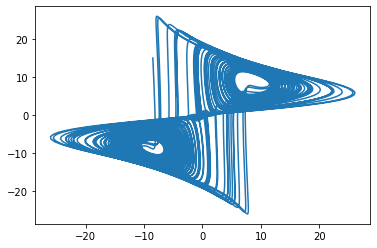

In [41]:
plt.plot(xx[:,0], xx[:,1])

In [58]:
len(xx)*.75

7459.5

In [ ]:
xtrain = xx[:len(xx)]

In [53]:
knn = neighbors.KNeighborsRegressor(n_neighbors=2)
knn.fit(xx,xx)

KNeighborsRegressor(n_neighbors=2)

In [54]:
dist, idx = knn.kneighbors(xx)

In [55]:
idx

array([[   0, 6501],
       [   1, 2934],
       [   2, 2935],
       ...,
       [9943, 7381],
       [9944, 7382],
       [9945, 7383]])

In [56]:
dist

array([[0.        , 1.418031  ],
       [0.        , 1.31336849],
       [0.        , 1.08281156],
       ...,
       [0.        , 0.18743219],
       [0.        , 0.16318981],
       [0.        , 0.13806463]])

In [18]:
X.shape

(10000, 3)

In [13]:
np.roll(X[:,1], 1)

array([-4.31641479,  1.        ,  1.2599461 , ..., -4.43728303,
       -4.39038935, -4.34837054])

In [14]:
X[:,1]

array([ 1.        ,  1.2599461 ,  1.52405449, ..., -4.39038935,
       -4.34837054, -4.31641479])